# Assignment 2-c   - Mirsaeid Abolghasemi

c) Write a colab to demonstrate the mixup, label smoothing, cutout  and test time augmentation with proper ablation studies on a small data set

# Installing fastbook

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.7MB/s 
     |████████████████████████████████| 358kB 13.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 1.0MB 35.6MB/s 
     |████████████████████████████████| 40kB 2.3MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 2.6MB 57.2MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *


In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [4]:
path2 = untar_data(URLs.CIFAR)

In [5]:
path2

Path('/root/.fastai/data/cifar10')

In [6]:
path

Path('/root/.fastai/data/imagenette2')

# Presizing

In [7]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

# Training

In [8]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.613561,2.507673,0.414488,02:43
1,1.220401,1.465159,0.537341,02:49
2,0.955977,1.085705,0.693054,02:46
3,0.740310,0.680930,0.788275,02:47
4,0.599116,0.554673,0.823749,02:48


# Normalization

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4803, 0.4687, 0.4362], device='cuda:0'),
 TensorImage([0.2874, 0.2799, 0.3006], device='cuda:0'))

In [10]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [11]:
dls = get_dls(64, 224)


In [12]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0438,  0.0469,  0.1309], device='cuda:0'),
 TensorImage([1.2342, 1.2513, 1.3189], device='cuda:0'))

## Training the model after normalization

In [13]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.731569,1.779069,0.429052,02:47
1,1.258637,1.240259,0.609783,02:47
2,0.951788,0.918481,0.712099,02:46
3,0.730478,0.667080,0.786034,02:46
4,0.575166,0.545703,0.823376,02:46


# Progressive Resizing


In [14]:
dls = get_dls(128, 128)

## Training the model after resizing

In [15]:

learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.860123,1.892388,0.439881,02:05
1,1.282546,1.361729,0.573936,02:05
2,0.936270,0.856721,0.723301,02:04
3,0.709599,0.658148,0.789768,02:04


## Fine-tuning after replacing the DataLoaders inside the Learner

In [16]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.807740,1.306649,0.653473,02:46


epoch,train_loss,valid_loss,accuracy,time
0,0.633595,0.661911,0.788648,02:46
1,0.639583,0.809594,0.746453,02:45
2,0.584092,0.650141,0.790515,02:46
3,0.476385,0.426186,0.865945,02:46
4,0.439516,0.408064,0.875280,02:46


# Test Time Augmentation

In [17]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8775205612182617

# Mixup

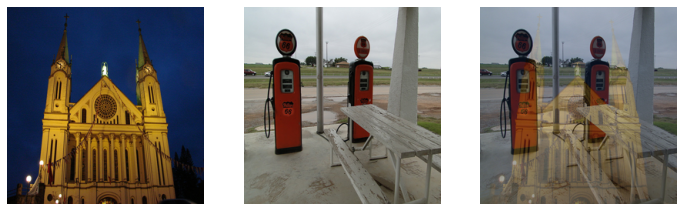

In [33]:
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[5])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[5])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

# Training again with Mixup

In [44]:
model = xresnet50()
mixup = MixUp(0.5)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=mixup)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.196625,2.868125,0.351755,02:12
1,1.763161,1.887251,0.468260,02:06
2,1.538365,1.056607,0.658327,02:06
3,1.356363,0.950874,0.700149,02:06
4,1.255896,0.732278,0.783794,02:05


# Label Smoothing

In [45]:
model = xresnet50()

Training after the label smooting (using loss_func=LabelSmoothingCrossEntropy())

In [46]:

learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.705988,2.853254,0.410007,02:04
1,2.212019,2.343669,0.550037,02:05
2,1.937455,1.827266,0.724795,02:05
3,1.754278,1.691090,0.768111,02:05
4,1.617466,1.595443,0.805825,02:05
